# Spatial correlation analyses

Load functions

In [1]:
import tempfile
import os
import nibabel as nib
import numpy as np
from nilearn import plotting
from scipy.stats import pearsonr


surfaces = dict()
surfaces['human_lh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/human/surfaces/S1200.L.very_inflated_MSMAll.10k_fs_LR.surf.gii"
surfaces['human_rh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/human/surfaces/S1200.R.very_inflated_MSMAll.10k_fs_LR.surf.gii"
surfaces['marmoset_lh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/marmoset/surfaces/surfFS.lh.pial.inflated.10k.surf.gii"
surfaces['marmoset_rh'] = "/mnt/WD10TB/datasets/data_view_crossspecies/marmoset/surfaces/surfFS.rh.pial.inflated.10k.surf.gii"

sing_shell="singularity exec -B /mnt/WD10TB -B / /home/geoff/Desktop/containers/fmriprep_ciftify-1.3.2-2.3.3"


def get_cortex_coords(species='human'):
    """
    Create cortex mask
    """
    
    X = np.ones((20484,))
    metric_data = {}
    metric_data['lh'] = X[:10242]
    metric_data['rh'] = X[10242:]
    mask = {}
    for hemi,metric in metric_data.items(): 
        mw = os.path.join(mapdir,"..","medialwall_mask",f"medialwall_{species}.{hemi}.shape.gii")
        mw = nib.load(mw).agg_data()
        cortex_coords = np.where(mw==0)
        mask[hemi] = cortex_coords
    
    return mask

def remap_array_onto_hemi(array,hemi,species='human'):
    
    cortex_coords = {}
    cortex_coords[species] = get_cortex_coords(species=species)
    
    X_ = np.zeros((10242,))
    for idx,coord in enumerate(cortex_coords[species][hemi][0]):
        X_[coord] = array[idx]
        
    return X_

/home/geoff/.virtualenvs/ConnectomeEmbeddings/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Compare human individual and joint somatomotor-default gradient

In [2]:
mapdir="/home/geoff/Desktop/Projects/InProgress/ConnectomeEmbeddings/notebooks/notebook_data/spatial_correlation_analyses/0_human_gradient_somatosensory_to_default"
def get_surrogates(type_,hemi,n_surr=1000,mapdir=mapdir):
    """
    RUN "generate surrogate map" notebook first
    In line with multiple regression analyses, myelinmap are also 
    Z-normalized before generating surrogates.
    """
    from brainsmash.mapgen.sampled import Sampled
    from brainsmash.mapgen.memmap import txt2memmap
    # Get paths
    mw = os.path.join(mapdir,"..","medialwall_mask",f"medialwall_human.{hemi}.shape.gii")
    mw = nib.load(mw).agg_data()
    species = 'human'
    cortex_coords = np.where(mw==0)
    if type_ == 'ind' and hemi == 'lh':
        brain_map_file = os.path.join(mapdir,"human-100UR.cortex-to-cortex.embedding-LE.thr-corr-0.1.lh.shape.gii")
    if type_ == 'ind' and hemi == 'rh':
        brain_map_file = os.path.join(mapdir,"human-100UR.cortex-to-cortex.embedding-LE.thr-corr-0.1.rh.shape.gii")
    if type_ == 'joint' and hemi == 'lh':
        brain_map_file = os.path.join(mapdir,"joint_eigenmap_human.lh.shape.gii")
    if type_ == 'joint' and hemi == 'rh':
        brain_map_file = os.path.join(mapdir,"joint_eigenmap_human.rh.shape.gii")

    metric = nib.load(brain_map_file).agg_data() # Load myelinmap
    metric = metric[1] # Select gradient
    # Get medial wall mask
    cortex_mask = np.ones((10242,))
    cortex_mask[cortex_coords] = 0
    brain_map_file = metric[cortex_coords[0]] # Get rid of medial wall
    # Load distmap into memory
    dist_mat_fin = f"../data/brainsmash/{species}_{hemi}_dense_geodesic_distmap.txt"
    output_files = txt2memmap(dist_mat_fin, '../data/brainsmash',maskfile=cortex_mask)
    # Generate surrogate myelin maps
    dist_mat_mmap = np.load(output_files['distmat'])
    index_mmap = np.load(output_files['index'])
    sampled = Sampled(brain_map_file,
                      dist_mat_mmap,
                      index_mmap)
    # Run
    surrogates = sampled(n=n_surr)
    
    return brain_map_file, surrogates

# Compare inter-cohort DMN RSN (obtained via melodic)

In [3]:
mapdir="/home/geoff/Desktop/Projects/InProgress/ConnectomeEmbeddings/notebooks/notebook_data/spatial_correlation_analyses/1_RSNs"
def get_surrogates(type_,hemi,n_surr=1000,mapdir=mapdir):
    """
    RUN "generate surrogate map" notebook first
    In line with multiple regression analyses, myelinmap are also 
    Z-normalized before generating surrogates.
    """
    from brainsmash.mapgen.sampled import Sampled
    from brainsmash.mapgen.memmap import txt2memmap
    # Get paths
    mw = os.path.join(mapdir,"..","medialwall_mask",f"medialwall_marmoset.{hemi}.shape.gii")
    mw = nib.load(mw).agg_data()
    species = 'marmoset'
    cortex_coords = np.where(mw==0)
    if type_ == 'ind' and hemi == 'lh':
        brain_map_file = os.path.join(mapdir,"cohort-UWO_melodic_IC.lh.shape.gii")
    if type_ == 'ind' and hemi == 'rh':
        brain_map_file = os.path.join(mapdir,"cohort-UWO_melodic_IC.rh.shape.gii")
    if type_ == 'joint' and hemi == 'lh':
        brain_map_file = os.path.join(mapdir,"cohort-NIH_melodic_IC.lh.shape.gii")
    if type_ == 'joint' and hemi == 'rh':
        brain_map_file = os.path.join(mapdir,"cohort-NIH_melodic_IC.rh.shape.gii")

    metric = nib.load(brain_map_file).agg_data() # Load myelinmap
    metric = metric[1] # Select gradient
    # Get medial wall mask
    cortex_mask = np.ones((10242,))
    cortex_mask[cortex_coords] = 0
    brain_map_file = metric[cortex_coords[0]] # Get rid of medial wall
    # Load distmap into memory
    dist_mat_fin = f"../data/brainsmash/{species}_{hemi}_dense_geodesic_distmap.txt"
    output_files = txt2memmap(dist_mat_fin, '../data/brainsmash',maskfile=cortex_mask)
    # Generate surrogate myelin maps
    dist_mat_mmap = np.load(output_files['distmat'])
    index_mmap = np.load(output_files['index'])
    sampled = Sampled(brain_map_file,
                      dist_mat_mmap,
                      index_mmap)
    # Run
    surrogates = sampled(n=n_surr)
    
    return brain_map_file, surrogates

# Run 
- edit inputs

marmoset lh
p-value: 0.0

marmoset rh
p-value: 0.0

{'lh': 0.8083127004699757, 'rh': 0.8407008554052902}


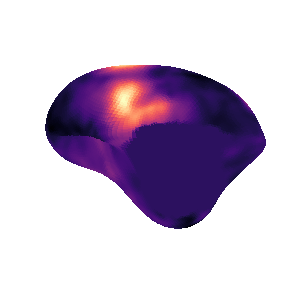

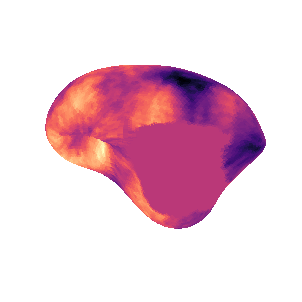

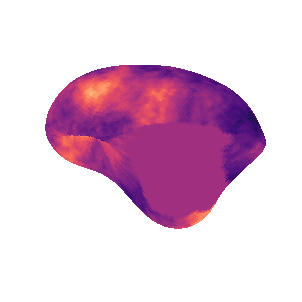

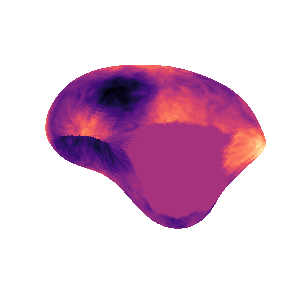

In [4]:
"""
Inputs
"""
type_='ind';hemi = 'lh'; n_surr=3; species='marmoset'
view_='medial'; hemi_='left'

"""
Run test on 2 surrogates & plot for sanity check
"""
metric, surrogates = get_surrogates(type_,hemi,n_surr=3)
x = plotting.plot_surf(surfaces[f"marmoset_{hemi}"],
                       remap_array_onto_hemi(metric,hemi=hemi,species=species),
                       view=view_,hemi=hemi_,
                       cmap='magma',symmetric_cmap=False)

for ix in range(3):
    x = plotting.plot_surf(surfaces[f"marmoset_{hemi}"],
                           remap_array_onto_hemi(surrogates[ix,:],hemi=hemi,species=species),
                           view=view_,hemi=hemi_,
                           cmap='magma',symmetric_cmap=False)

"""
Statistics
"""
from scipy.stats import pearsonr

null = {}
test = {}
for hemi in ['lh','rh']:
    joint_metric, _ = get_surrogates('joint',hemi,n_surr=1)
    null[f"{hemi}"] = np.zeros((n_surr,))
    ind_metric, surrogates = get_surrogates('ind',hemi,n_surr=n_surr)
    test[f"{hemi}"] = pearsonr(joint_metric,ind_metric)[0]
    for ix in range(n_surr):
        null[f"{hemi}"][ix] = pearsonr(joint_metric,surrogates[ix,:])[0]
    pval = (test[f"{hemi}"]<null[f"{hemi}"]).sum()/n_surr
    print(f"{species} {hemi}\np-value: {pval}\n")
    
print(test)

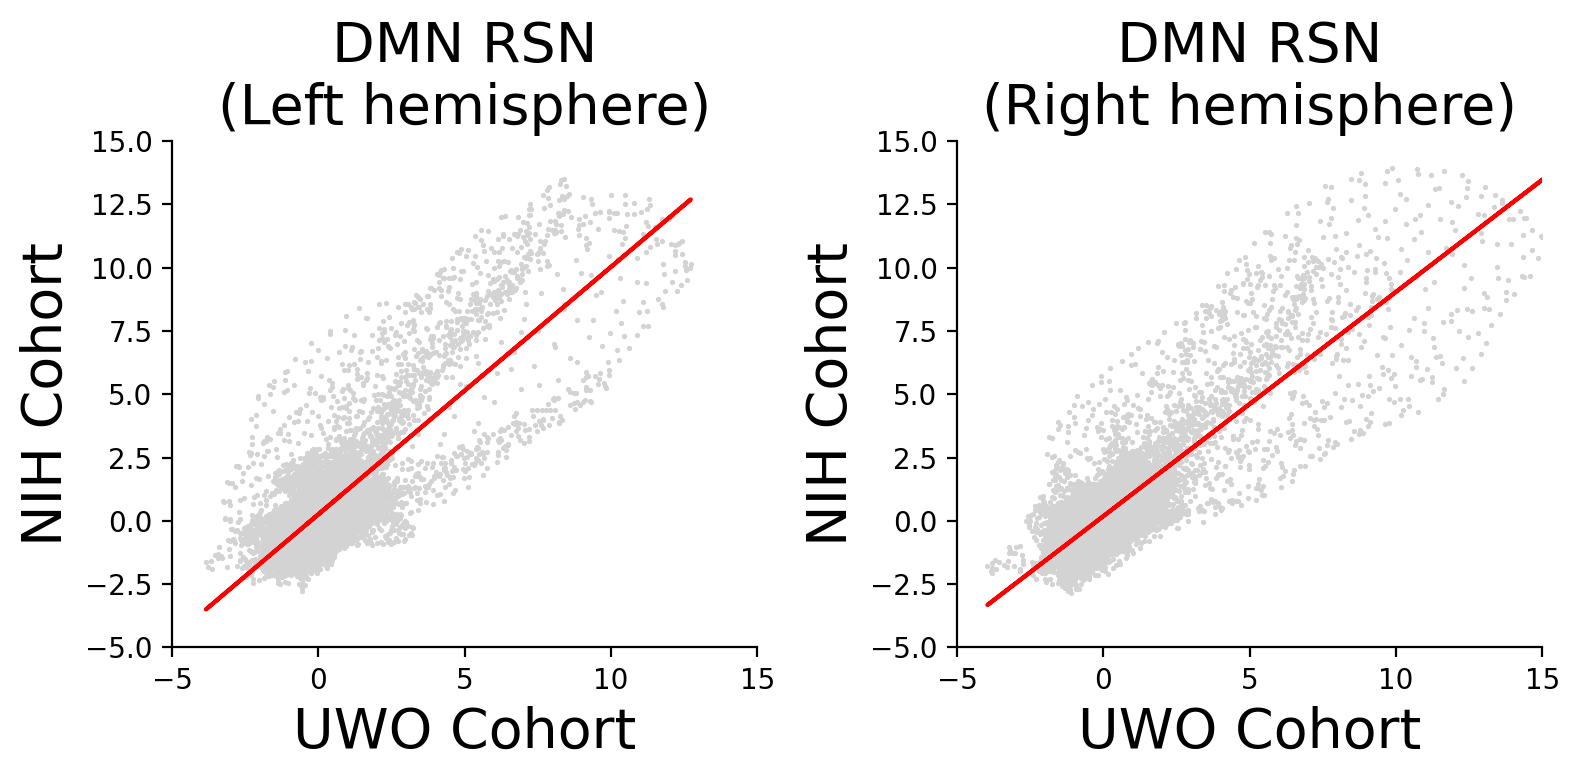

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bestfit_line(x,y,ax):
    m, b = np.polyfit(x,y,1)
    ax.plot(x, m*x + b,c='red')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,
                               figsize=(8,4),dpi=200)

hemi = 'lh' # Left hemisphere
x, _ = get_surrogates('joint',hemi,n_surr=1)
y, _ = get_surrogates('ind',hemi,n_surr=1)

#sns.kdeplot(x, y, marker='.', kind='reg', n_levels=1, cmap="magma",ax=ax1)
ax1.scatter(x,y,s=.8,c='lightgrey')
plot_bestfit_line(x,y,ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_xlim([-5,15])
ax1.set_ylim([-5,15])

ax1.set_title('DMN RSN\n(Left hemisphere)',fontsize=20)
ax1.set_xlabel(f"UWO Cohort",fontsize=20)
ax1.set_ylabel(f"NIH Cohort",fontsize=20)

hemi = 'rh' # Right hemisphere
x, _ = get_surrogates('joint',hemi,n_surr=1)
y, _ = get_surrogates('ind',hemi,n_surr=1)

#sns.kdeplot(x, y, marker='.', kind='reg', n_levels=5, cmap="magma",ax=ax1)
ax2.scatter(x,y,s=.8,c='lightgrey')
plot_bestfit_line(x,y,ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.set_xlim([-5,15])
ax2.set_ylim([-5,15])

ax2.set_title('DMN RSN\n(Right hemisphere)',fontsize=20)
ax2.set_xlabel(f"UWO Cohort",fontsize=20)
ax2.set_ylabel(f"NIH Cohort",fontsize=20)

"""for ax in [ax1,ax2]:
    ax.set_xticklabels([-5,0,5,10,15],fontsize=15)
    ax.set_yticklabels([-5,0,5,10,15],fontsize=15)"""

plt.tight_layout()

# SAVE FIGURE
plt.savefig(os.path.join('figures',f"individual_vs_joint_human_gradient1.jpg"),dpi=1080,bbox_inches='tight')